# PLAN

 - Диалоговый датасет
     - BANKING77
     - CLINC150
     - HWU64
     - https://github.com/google-research-datasets/dstc8-schema-guided-dialogue
 - Генератор (XLM-R)
     - придумать как генерировать токен на другом языке
     - применить к задачке
 - LABSE для полученных и исходных предложений
     - сделать кастомный класс лосса

Для XLM-R:

Занулить веса на выходе для всех языков кроме русского (пройтись по всем токенам и регулярочкой выявить те токены, которые относятся к русскому). Перед backward занулять градиенты по всем токенам не из русского, ибо торч не даст ставить requires_grad на отдельную часть тензора.

Как вариант - написать обертку над моделью, которая будет иметь меньший размер выходной головы, потом делать новый тензор с нулями на месте других языков и выходом модели для русского.

In [15]:
import json
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch

import sys

sns.set(style='darkgrid', rc={'figure.figsize': (16, 9)})
sys.path.append('..')

with open('../data/dstc_utterances.json') as f:
    data = json.load(f)

texts, intents = zip(*((elem['text'], elem['intent']) for elem in data))

In [2]:
len(texts), len(np.unique(intents))

(61767, 46)

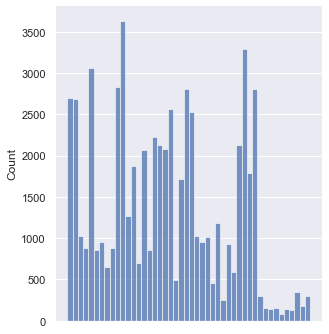

In [3]:
sns.displot(intents)
plt.xticks([])
plt.show()

In [4]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

model_name = 'xlm-roberta-base'

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForMaskedLM.from_pretrained(model_name)

In [8]:
import regex

def is_cyrillic(s: str):
    return bool(regex.search(r'\p{IsCyrillic}', s))


russian_tokens_mask = np.zeros(model.lm_head.decoder.weight.shape[0])

for token in range(model.lm_head.decoder.weight.shape[0]):
    if is_cyrillic(tokenizer.decode([token])):
        russian_tokens_mask[token] = 1

In [9]:
russian_tokens_mask = russian_tokens_mask.astype(bool)

In [10]:
russian_tokens_mask.sum()

31671

In [11]:
with torch.no_grad():
    model.lm_head.decoder.weight[~russian_tokens_mask] = 0

In [170]:
sequence = f'I have a {tokenizer.mask_token}.'

inputs = tokenizer.encode(sequence, return_tensors='pt')
mask_token_index = torch.where(inputs == tokenizer.mask_token_id)[1]

token_logits = model(inputs).logits
mask_token_logits = token_logits[0, mask_token_index, :]

torch.sum(torch.nn.functional.gumbel_softmax(mask_token_logits, hard=True) * torch.arange(0, mask_token_logits.shape[1]))

tensor(59., grad_fn=<SumBackward0>)

In [186]:
outputs = inputs.float()
outputs[inputs == tokenizer.mask_token_id] = torch.sum(torch.nn.functional.gumbel_softmax(mask_token_logits, hard=True) * torch.arange(0, mask_token_logits.shape[1]))

In [187]:
outputs

tensor([[  0.,  87., 765.,  10., 983.,   6.,   5.,   2.]],
       grad_fn=<IndexPutBackward>)

In [188]:
outputs2 = outputs.long()

In [197]:
outputs.grad_fn

In [198]:
outputs2.grad_fn = outputs.grad_fn

AttributeError: attribute 'grad_fn' of 'torch._C._TensorBase' objects is not writable

In [185]:
outputs2

In [166]:
inputs = tokenizer.encode(sequence, return_tensors='pt')
mask_token_index = torch.where(inputs == tokenizer.mask_token_id)[1]

In [169]:
inputs[inputs == tokenizer.mask_token_id] = torch.sum(torch.nn.functional.gumbel_softmax(mask_token_logits, hard=True) * torch.arange(0, mask_token_logits.shape[1]))

RuntimeError: Index put requires the source and destination dtypes match, got Long for the destination and Float for the source.

In [162]:
inputs

tensor([[0.0000e+00, 8.7000e+01, 7.6500e+02, 1.0000e+01, 2.0384e+05, 6.0000e+00,
         5.0000e+00, 2.0000e+00]], grad_fn=<IndexPutBackward>)

In [157]:
mask_token_index.item()

4

In [80]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel


class CustomLoss(nn.Module):
    """
    Custom loss counting similarity between target and output sentence
    """

    def __init__(self, device):
        super().__init__()

        self.model_name = 'sentence-transformers/xlm-r-100langs-bert-base-nli-mean-tokens'
        self.model = AutoModel.from_pretrained(self.model_name).to(device)
        self.model.eval()

    def forward(self, outputs, labels):
        outputs_1 = self.model(**outputs)
        outputs_2 = self.model(**labels)

        embeddings_1 = outputs_1.pooler_output
        embeddings_2 = outputs_2.pooler_output

        normalized_embeddings_1 = F.normalize(embeddings_1, p=2)
        normalized_embeddings_2 = F.normalize(embeddings_2, p=2)

        return normalized_embeddings_1 @ normalized_embeddings_2.transpose(0, 1)


In [81]:
loss = CustomLoss(torch.device('cuda:0'))

In [82]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')